# 3.Computer Vision : CNN for digit recognition 

In [3]:
import torch 
import torch.cuda as cuda 
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.autograd import Variable 

from torchvision import datasets
from torchvision import transforms 

import torch.nn.functional as F

In [4]:
## Create data loader
mean_gray = 0.1307
stddev_gray = 0.3081 
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((mean_gray,),(stddev_gray,))])

mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_valid = datasets.MNIST('./data', train=False, download=True, transform=transform)

Processing...
Done!


In [5]:
img = mnist_train[12][0].numpy() * stddev_gray + mean_gray


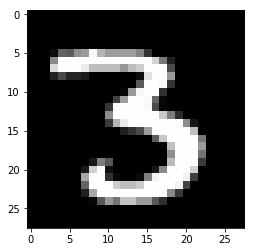

In [6]:
plt.imshow(img.reshape(28, 28), cmap='gray')


In [7]:
label = mnist_train[12][1]
label

tensor(3)

In [8]:
batch_size= 1024

In [9]:
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
mnist_valid_loader = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, shuffle=True, num_workers=1)

In [19]:
class MNISTNet(nn.Module):
    
    def __init__(self):
        super().__init__()
               
        # NOTE: All Conv2d layers have a default padding of 0 and stride of 1,
        # which is what we are using.
        
        # Convolution Layer 1                             # 28 x 28 x 1  (input)
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)      # 24 x 24 x 20  (after 1st convolution)
        self.relu1 = nn.ReLU()                            # Same as above
        
        # Convolution Layer 2
        self.conv2 = nn.Conv2d(20, 30, kernel_size=5)     # 20 x 20 x 30  (after 2nd convolution)
        self.conv2_drop = nn.Dropout2d(p=0.5)             # Same as above
        self.maxpool2 = nn.MaxPool2d(2)                   # 10 x 10 x 30  (after pooling)
        self.relu2 = nn.ReLU()                            # Same as above 
        
        # Fully connected layers
        self.fc1 = nn.Linear(3000, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        
        # Convolution Layer 1                    
        x = self.conv1(x)                        
        x = self.relu1(x)                        
        
        # Convolution Layer 2
        x = self.conv2(x)               
        x = self.conv2_drop(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        
        # Switch from activation maps to vectors
        x = x.view(-1, 3000)
        
        # Fully connected layer 1
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=True)
        
        # Fully connected layer 2
        x = self.fc2(x)
        
        return x

# Create the Object

In [20]:
# Model
net = MNISTNet()

if cuda.is_available():
    net = net.cuda()
    

# Our loss function
criterion = nn.CrossEntropyLoss()

#Optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(net.parameters(),lr = learning_rate, momentum = 0.9)


    
    
    
    


# Training Loop

In [ ]:
num_epochs = 100

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    
    ############################
    # Train
    ############################
    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    net.train()                   # Put the network into training mode
    
    for i, (items, classes) in enumerate(mnist_train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        optimizer.zero_grad()     # Clear off the gradients from any past operation
        outputs = net(items)      # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        iter_loss += loss.item() # Accumulate the loss
        loss.backward()           # Calculate the gradients with help of back propagation
        optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(mnist_train_loader.dataset)))
    
    
    ############################
    # Validate - How did we do on the unseen dataset?
    ############################
    
    loss = 0.0
    correct = 0
    iterations = 0

    net.eval()                    # Put the network into evaluate mode
    
    for i, (items, classes) in enumerate(mnist_valid_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        outputs = net(items)      # Do the forward pass
        loss += criterion(outputs, classes).item() # Calculate the loss
        
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    # Record the validation loss
    valid_loss.append(loss/iterations)
    # Record the validation accuracy
    valid_accuracy.append(correct / len(mnist_valid_loader.dataset) * 100.0)

    
    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
           %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             valid_loss[-1], valid_accuracy[-1]))